# Benchmarking Feedforward Network on BAF Dataset

Quick sanity-check notebook to ensure the reusable components under `src/` work nicely together on the Bank Account Fraud (BAF) dataset.

## 1. Import BAF data

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from src import paths
from src.data.datasets import make_loaders, TabularTensorDataset
from src.io_ops import read_csv_safely
from src.models.ffn import FeedforwardNetwork
from src.optim.factory import create_optimizer, create_scheduler
from src.training.engine import train_one_epoch, evaluate
from src.training.metrics import get_loss_fn, accuracy
from src.viz.plots import plot_loss, plot_metric

torch.manual_seed(42)
np.random.seed(42)

csv_path = paths.RAW_DATA_DIR / "Base.csv"
raw_df = read_csv_safely(csv_path)

numeric_df = raw_df.select_dtypes(include=[np.number]).copy()
target_col = "fraud_bool"
feature_cols = [col for col in numeric_df.columns if col != target_col]

X = numeric_df[feature_cols].to_numpy(dtype=np.float32)
y = numeric_df[target_col].to_numpy(dtype=np.int64)

print(f"Loaded {len(raw_df):,} rows with {len(feature_cols)} numeric features.")
print(f"Positive rate: {y.mean():.2%}")

Loaded 1,000,000 rows with 26 numeric features.
Positive rate: 1.10%


## 2. Data split

In [4]:
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15, seed=42):
    rng = np.random.default_rng(seed)
    indices = np.arange(len(X))
    rng.shuffle(indices)
    n_train = int(len(X) * train_ratio)
    n_val = int(len(X) * val_ratio)
    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]
    return (
        X[train_idx],
        y[train_idx],
        X[val_idx],
        y[val_idx],
        X[test_idx],
        y[test_idx],
    )

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)

train_loader, val_loader = make_loaders(
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size=512,
)

test_dataset = TabularTensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(
    f"Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}"
)

Train: 700000 | Val: 150000 | Test: 150000


## 3. Create a FFN model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train.shape[1]

model = FeedforwardNetwork(
    n_classes=2,
    n_features=n_features,
    hidden_layers=[
        {"units": 256, "activation": "relu", "dropout": 0.2},
        {"units": 128, "activation": "relu", "dropout": 0.2},
        64,
    ],
    default_dropout=0.1,
)

model.to(device)
model

FeedforwardNetwork(
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=26, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)

## 4. Optimizer and scheduler

In [6]:
loss_fn = get_loss_fn("multiclass")
optimizer_cfg = {"name": "adamw", "lr": 3e-4, "weight_decay": 1e-2}
optimizer = create_optimizer(model, optimizer_cfg)
scheduler_cfg = {"name": "cosine", "t_max": 10}
scheduler = create_scheduler(optimizer, scheduler_cfg)
metric_fns = {"accuracy": accuracy}


## 5. Train for some epochs

In [7]:
num_epochs = 10
history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch(
        model,
        train_loader,
        optimizer,
        loss_fn,
        device,
        metric_fns,
    )
    val_metrics = evaluate(
        model,
        val_loader,
        loss_fn,
        device,
        metric_fns,
    )

    history["train_loss"].append(train_metrics["loss"])
    history["train_accuracy"].append(train_metrics["accuracy"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_accuracy"].append(val_metrics["accuracy"])

    if scheduler is not None:
        scheduler.step()

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_metrics['loss']:.4f}, val_loss={val_metrics['loss']:.4f} | "
        f"train_acc={train_metrics['accuracy']:.4f}, val_acc={val_metrics['accuracy']:.4f}"
    )

Epoch 01 | train_loss=0.3307, val_loss=0.0659 | train_acc=0.9853, val_acc=0.9892
Epoch 02 | train_loss=0.0703, val_loss=0.0624 | train_acc=0.9888, val_acc=0.9892
Epoch 03 | train_loss=0.0666, val_loss=0.0658 | train_acc=0.9889, val_acc=0.9892
Epoch 04 | train_loss=0.0648, val_loss=0.0611 | train_acc=0.9889, val_acc=0.9892
Epoch 05 | train_loss=0.0638, val_loss=0.0628 | train_acc=0.9889, val_acc=0.9892
Epoch 06 | train_loss=0.0628, val_loss=0.0671 | train_acc=0.9889, val_acc=0.9892
Epoch 07 | train_loss=0.0622, val_loss=0.0645 | train_acc=0.9889, val_acc=0.9892
Epoch 08 | train_loss=0.0619, val_loss=0.0607 | train_acc=0.9889, val_acc=0.9892
Epoch 09 | train_loss=0.0613, val_loss=0.0624 | train_acc=0.9889, val_acc=0.9892
Epoch 10 | train_loss=0.0612, val_loss=0.0613 | train_acc=0.9889, val_acc=0.9892


## 6. Plot the training results

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

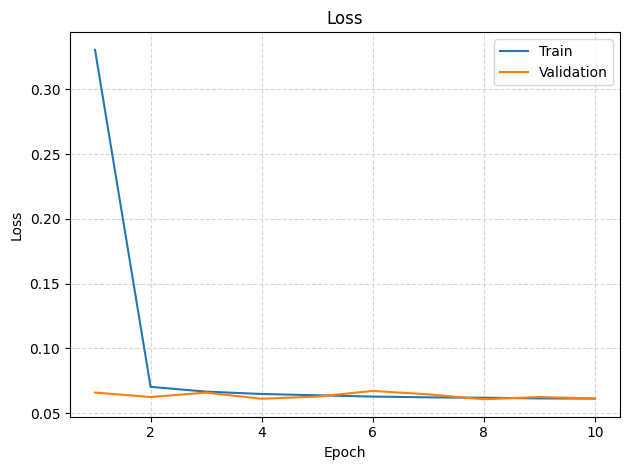

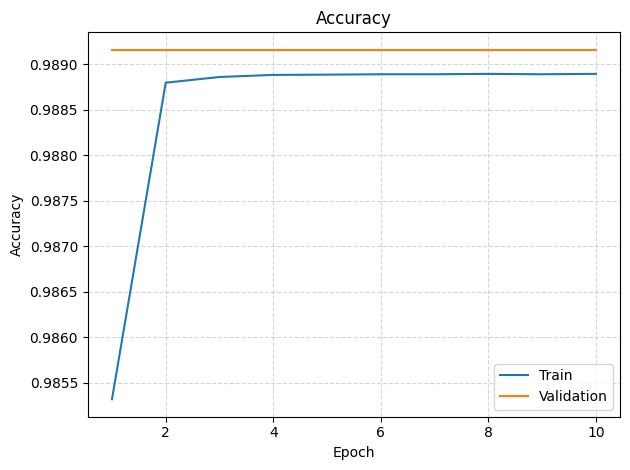

In [8]:
fig_loss = plot_loss(history)
fig_accuracy = plot_metric(history, "accuracy", title="Accuracy")
fig_loss, fig_accuracy

## 7. Evaluate on the test split

In [9]:
test_metrics = evaluate(model, test_loader, loss_fn, device, metric_fns)
for name, value in test_metrics.items():
    print(f"{name}: {value:.4f}")

loss: 0.0615
accuracy: 0.9891
